# Context

A time series is a dataset where observations are indexed in chronological order and often exhibit temporal dependencies, including components such as trend and seasonality. In this notebook, we will forecast the target variable using its past values. In the next notebook, we will analyze and model the residuals, which, ideally, should no longer exhibit temporal dependency if the primary model is adequate.

# Set up

In [1]:
## Base
import numpy as np
import pandas as pd
import os

## Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#003366'])

# Funções criadas
import sys
from pathlib import Path
sys.path.insert(1, Path.cwd().parents[0].as_posix())

from src.ts_utils import *
from config import *

In [2]:
import statsmodels.api as sm
import scipy.optimize as opt

from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
# from statsmodels.tsa.seasonal import seasonal_decompose

# from pmdarima.arima import auto_arima

# from scipy.stats import boxcox, shapiro
# from statsmodels.stats.diagnostic import het_breuschpagan
# from statsmodels.graphics.gofplots import qqplot
# from statsmodels.tsa.stattools import adfuller
# from statsmodels.graphics.tsaplots import plot_acf

## Functions

In [4]:
def compute_metrics(y, y_pred):
    ss_total = np.sum((y - np.mean(y))**2)
    ss_residual = np.sum((y - y_pred)**2)
    r2_se = 1 - (ss_residual / ss_total)
    
    ae_total = np.sum(np.abs(y - np.mean(y)))
    ae_residual = np.sum(np.abs(y - y_pred))
    r2_ae = 1 - (ae_residual / ae_total)
    
    mae = np.mean(np.abs(y - y_pred))
    rmse = np.sqrt(np.mean((y - y_pred)**2))
    
    return r2_se, r2_ae, mae, rmse

# Data  
We will use the sanitized data from the previous notebook.  

In [5]:
weather_df_complete = pd.read_parquet('../data/wrangle/weather_sanitized.parquet')
weather_df = weather_df_complete.loc[weather_df_complete['time'].dt.year < 2024].copy()

In [6]:
display(weather_df.tail())
weather_df.info()

,time,tavg,prcp,snow,wspd,pres,tamp,wcardinal
1829,2023-12-27,277.2,0.0,0.0,4.3,1016.0,7.3,Northeast
1830,2023-12-28,278.0,5.8,0.0,4.8,1009.7,3.4,North
1831,2023-12-29,277.9,6.1,0.0,4.8,1009.9,6.7,North
1832,2023-12-30,274.1,0.0,0.0,3.6,1011.8,5.6,Southwest
1833,2023-12-31,274.4,0.5,0.0,4.9,1014.5,3.3,West


<class 'pandas.core.frame.DataFrame'>
Index: 1834 entries, 0 to 1833
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   time       1834 non-null   datetime64[ns]
 1   tavg       1834 non-null   float64       
 2   prcp       1834 non-null   float64       
 3   snow       1834 non-null   float64       
 4   wspd       1834 non-null   float64       
 5   pres       1834 non-null   float64       
 6   tamp       1834 non-null   float64       
 7   wcardinal  1834 non-null   category      
dtypes: category(1), datetime64[ns](1), float64(6)
memory usage: 116.8 KB


# Target Variable  
Below, we present our time series in a visualization that allows us to derive insights, such as potential seasonality — particularly annual seasonality— and the overall trend of the series. Additionally, we conduct two stationarity tests: Augmented Dickey-Fuller (ADF) and Kwiatkowski-Phillips-Schmidt-Shin (KPSS).  

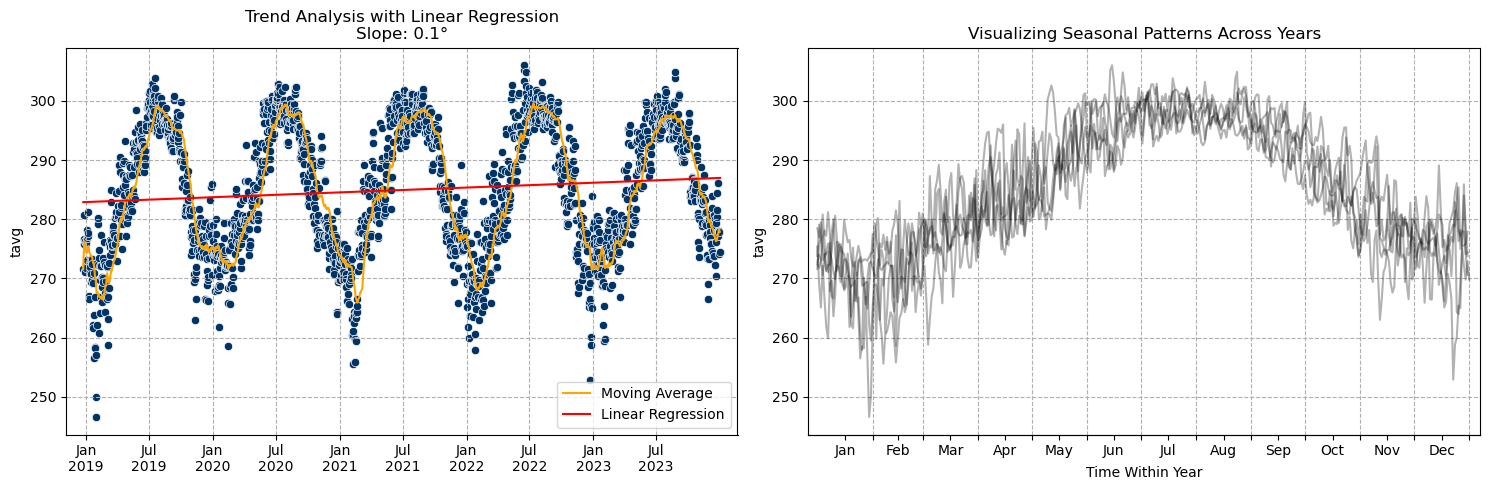

Augmented Dickey-Fuller (ADF) - p-value: 15.14%
	Ho: Non-Stationarity 
	Ha: Is Stationary
	
Kwiatkowski-Phillips-Schmidt-Shin (KPSS) - p-value: 10.00%
	Ho: Is Stationary
	Ha: Non-Stationarity
	


C:\Users/PedroMoura/Documents/GitHub/WeatherForecast\src\ts_utils.py:40: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  print(f"Kwiatkowski-Phillips-Schmidt-Shin (KPSS) - p-value: {kpss(serie)[1]:.2%}\n"


In [7]:
ts_quick_insights(weather_df['tavg'], weather_df['time'])
stationary_tests(weather_df['tavg'])

The series exhibits clear seasonality but no apparent trend. The presence of seasonality may explain its non-stationarity, as its statistical properties change periodically. Additionally, as observed in the sanity check, the series exhibits heteroscedasticity, meaning its variance changes over time, adding complexity to the modeling process.  

The first step is to transform the data to achieve stationarity, a necessary condition for many time series models. Several transformations are possible; however, since our objective is to forecast temperature over a one-year window, we will focus on achieving stationarity by removing seasonality using harmonic regression.  

## Stationarity

### Harmonic Regression
From the graph, we observe that lower temperatures correspond to higher variability, indicating seasonal heteroscedasticity. This variability complicates the identification of outliers, as standard deviation-based methods may misclassify points. To address this, we will use three different regression approaches and compare their results.

**Selected Regression Models**:
- **Ordinary Least Squares (OLS)**: Minimizes squared residuals, providing an optimal fit under homoscedasticity.
- **Quantile Regression**: Estimates conditional quantiles, offering robustness against heteroscedasticity and outliers.
- **Root Square Absolute Error (RSAE) Regression**: Balances squared and absolute errors, making it less sensitive to extreme values than OLS.

**Evaluation Metrics**:<br>
To assess model performance, we will compute the following metrics:
- **$𝑅^2$ (Squared Errors)**: Measures explained variance using squared residuals.
- **$𝑅^2$ (Absolute Errors)**: Similar to $𝑅^2$ but based on absolute deviations, providing robustness to outliers.
- **Mean Absolute Error (MAE)**: Measures the average absolute difference between predictions and actual values.
- **Root Mean Squared Error (RMSE)**: Penalizes larger errors more than MAE, emphasizing extreme deviations.
- **First and Third Quartiles of the Residuals**: Evaluates the spread and skewness of residuals.
- **Residual Amplitude**: Measures the range between the highest and lowest residuals, assessing model stability.

In [8]:
media_dia_ano = 365.242189
w = 2 * np.pi / media_dia_ano

t = np.arange(len(weather_df))  # Assuming daily data
X = np.column_stack([np.sin(w * t), np.cos(w * t)])
X = sm.add_constant(X)  # Adicionando intercepto à regressão
y = weather_df['tavg'].values


**Ordinary Least Squares (OLS)**  
A classical approach and an excellent starting point. However, it may not achieve the best results due to the heteroscedastic behavior of the data.

In [9]:
# Ajustando o modelo de regressão harmônica
model_harm = sm.OLS(weather_df['tavg'].dropna(), X).fit()

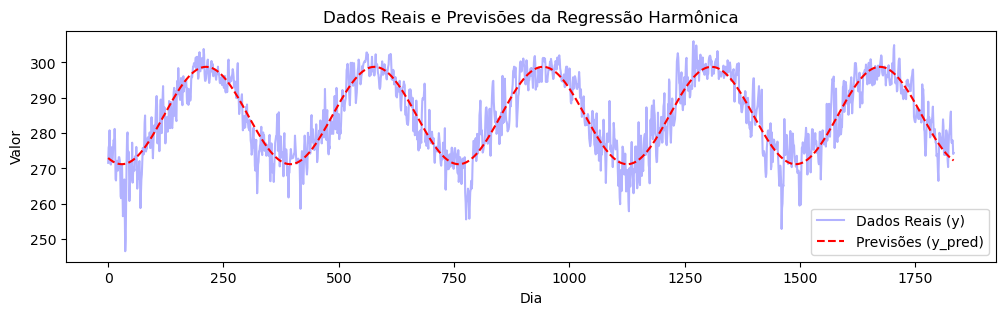

                            OLS Regression Results                            
Dep. Variable:                   tavg   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     4040.
Date:                Mon, 03 Mar 2025   Prob (F-statistic):               0.00
Time:                        02:12:36   Log-Likelihood:                -5417.3
No. Observations:                1834   AIC:                         1.084e+04
Df Residuals:                    1831   BIC:                         1.086e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        284.9856      0.108   2627.668      0.0

In [10]:
# Gerando as previsões do modelo
harmonic_ols = model_harm.predict(X)

# Visualizando os dados reais e as previsões
plt.figure(figsize=(12, 3))
plt.plot(t, weather_df['tavg'].dropna(), label='Dados Reais (y)', color='blue', alpha=0.3)
plt.plot(t, harmonic_ols, label='Previsões (y_pred)', color='red', linestyle='--')
plt.title('Dados Reais e Previsões da Regressão Harmônica')
plt.xlabel('Dia')
plt.ylabel('Valor')
plt.legend()
plt.show()

# Resultados da regressão
print(model_harm.summary())

**Quantile Regression (LAD)**

A robust regression method for handling heteroscedasticity and outliers, as it estimates conditional quantiles (e.g., the median) rather than the mean. Unlike Ordinary Least Squares (OLS), which minimizes squared residuals, quantile regression minimizes absolute residuals for a given quantile, making it less sensitive to extreme values.

In [11]:
# Ajustando o modelo de regressão harmônica
model_harmonic_lad = sm.QuantReg(weather_df['tavg'], X).fit()

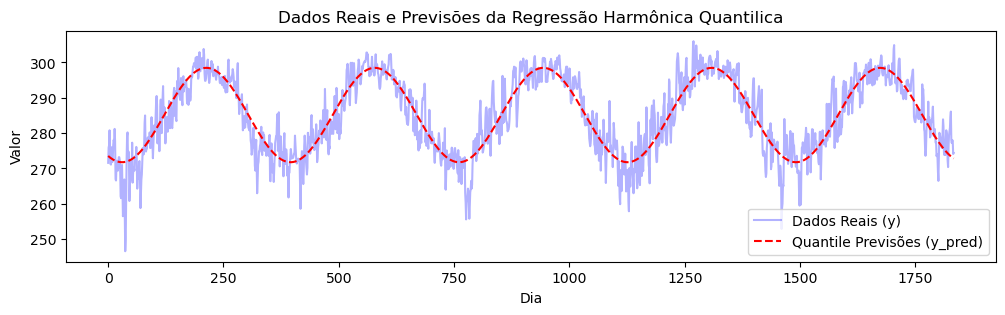

                         QuantReg Regression Results                          
Dep. Variable:                   tavg   Pseudo R-squared:               0.6248
Model:                       QuantReg   Bandwidth:                       1.606
Method:                 Least Squares   Sparsity:                        10.01
Date:                Mon, 03 Mar 2025   No. Observations:                 1834
Time:                        02:12:36   Df Residuals:                     1831
                                        Df Model:                            2
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        285.1216      0.117   2439.537      0.000     284.892     285.351
x1            -6.6197      0.166    -39.966      0.000      -6.945      -6.295
x2           -11.5880      0.165    -70.256      0.000     -11.912     -11.265


In [12]:
# Gerando as previsões do modelo
harmonic_lad = model_harmonic_lad.predict(X)

# Visualizando os dados reais e as previsões
plt.figure(figsize=(12, 3))
plt.plot(t, weather_df['tavg'].dropna(), label='Dados Reais (y)', color='blue', alpha=0.3)
plt.plot(t, harmonic_lad, label='Quantile Previsões (y_pred)', color='red', linestyle='--')
plt.title('Dados Reais e Previsões da Regressão Harmônica Quantilica')
plt.xlabel('Dia')
plt.ylabel('Valor')
plt.legend()
plt.show()

# Resultados da regressão
print(model_harmonic_lad.summary())

**Root Square Absolute Error (RSAE) Regression**

This method estimates the conditional mean while being more robust to outliers and heteroscedasticity than Ordinary Least Squares (OLS). Instead of minimizing squared residuals (as in OLS) or absolute residuals (as in quantile regression), RSAE minimizes the square root of absolute errors, striking a balance between the two. However, its optimization process is more complex, which may affect computational performance depending on the dataset and model choice.

In [13]:
# Define the root error loss function
def root_error_loss(beta, X, y):
    residuals = y - X @ beta
    return np.sum(np.sqrt(np.abs(residuals)))

# Initial guess for coefficients
beta_init = np.zeros(X.shape[1])

# Optimize using Powell's method (gradient-free)
result = opt.minimize(root_error_loss, beta_init, args=(X, y), method="Powell")

Optimized Coefficients: [285.16454559  -6.5539977  -11.37057532]


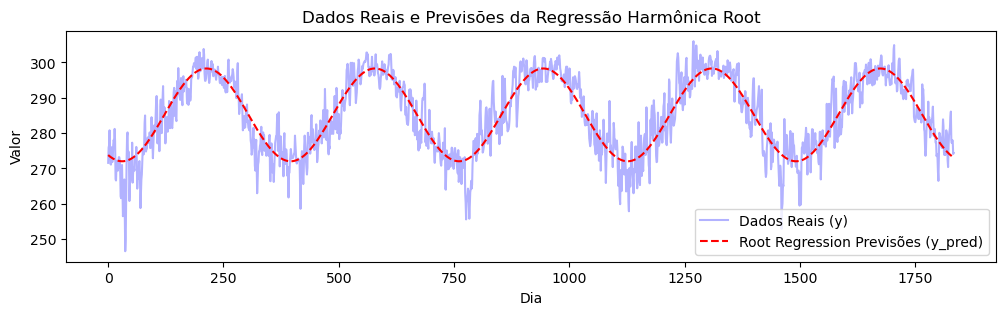

In [14]:
# Extract optimized coefficients
beta_hat = result.x
print("Optimized Coefficients:", beta_hat)

# Compute fitted values
harmonic_rsae = X @ beta_hat

# Visualizando os dados reais e as previsões
plt.figure(figsize=(12, 3))
plt.plot(t, weather_df['tavg'].dropna(), label='Dados Reais (y)', color='blue', alpha=0.3)
plt.plot(t, harmonic_rsae, label='Root Regression Previsões (y_pred)', color='red', linestyle='--')
plt.title('Dados Reais e Previsões da Regressão Harmônica Root')
plt.xlabel('Dia')
plt.ylabel('Valor')
plt.legend()
plt.show()

**Comparison**  
With all models trained, we proceed to compare them. Below, we present the distribution of residuals for each model. At first glance, there are no striking differences between the methods. However, visual analysis alone is not sufficient to determine the best approach.

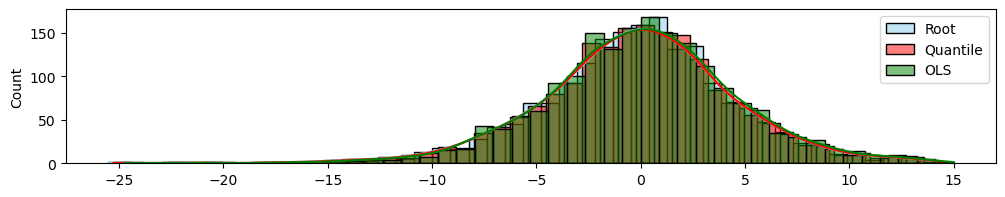

In [15]:
plt.figure(figsize=(12, 2))

sns.histplot(x=y - harmonic_rsae, color="skyblue", label="Root", kde=True)
sns.histplot(x=y - harmonic_lad, color="red", label="Quantile", kde=True)
sns.histplot(x=y - harmonic_ols, color="green", label="OLS", kde=True)

plt.legend() 
plt.show()

Below is a report presenting multiple metrics for model comparison. While each metric provides valuable insights, it is important to emphasize that our primary goal is to forecast temperatures over a long window while maintaining reliability.

In [16]:
# Compute metrics for each model
metrics = {
    "Model": ["OLS", "LAD", "RSAE"],
    "R² (Squared Errors)": [],
    "R² (Absolute Errors)": [],
    "MAE": [],
    "RMSE": [],
    "Q1": [],
    "Q3": [],
    "Amplitude": []
}

for y_pred in [harmonic_ols, harmonic_lad, harmonic_rsae]:
    r2_se, r2_ae, mae, rmse = compute_metrics(y, y_pred)
    q1, q3 = np.quantile(y-y_pred, [0.25, 0.75])
    metrics["R² (Squared Errors)"].append(r2_se)
    metrics["R² (Absolute Errors)"].append(r2_ae)
    metrics["MAE"].append(mae)
    metrics["RMSE"].append(rmse)
    metrics["Q1"].append(q1)
    metrics["Q3"].append(q3)
    metrics["Amplitude"].append(q3-q1)

# Convert to DataFrame for display
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

  Model  R² (Squared Errors)  R² (Absolute Errors)       MAE      RMSE  \
0   OLS             0.815242              0.623892  3.531920  4.640756   
1   LAD             0.814230              0.624840  3.523017  4.653441   
2  RSAE             0.813023              0.624476  3.526438  4.668540   

         Q1        Q3  Amplitude  
0 -2.683403  2.771384   5.454788  
1 -2.758011  2.614658   5.372668  
2 -2.808871  2.558300   5.367171  


Based on the presented metrics, selecting the best model requires balancing **forecast accuracy and reliability** over a one-year window in a dataset that is **heteroscedastic, seasonal, and non-stationary**.

Among the evaluated models:
- **Root Absolute Error Regression** had the smallest residual amplitude (5.367), indicating lower error variability and more stable confidence intervals.
- **Least Absolute Deviations (LAD) Regression** achieved the lowest Mean Absolute Error (MAE = 3.523), suggesting strong overall predictive accuracy.
- **Ordinary Least Squares (OLS)** obtained the lowest Root Mean Squared Error (RMSE = 4.641), but RMSE is more sensitive to outliers, making it less suitable for a heteroscedastic dataset.

Given this context, Root Absolute Error Regression was selected as the best model, as its lower residual amplitude reduces forecast uncertainty, making it more reliable for long-term predictions.

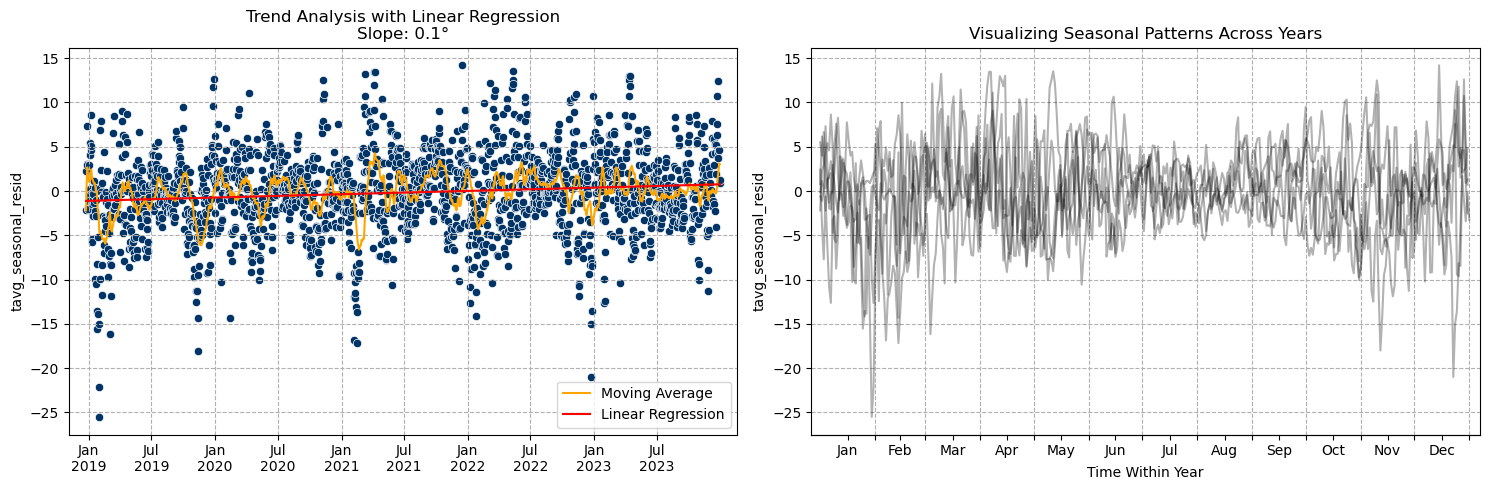

Augmented Dickey-Fuller (ADF) - p-value: 0.00%
	Ho: Non-Stationarity 
	Ha: Is Stationary
	
Kwiatkowski-Phillips-Schmidt-Shin (KPSS) - p-value: 2.82%
	Ho: Is Stationary
	Ha: Non-Stationarity
	


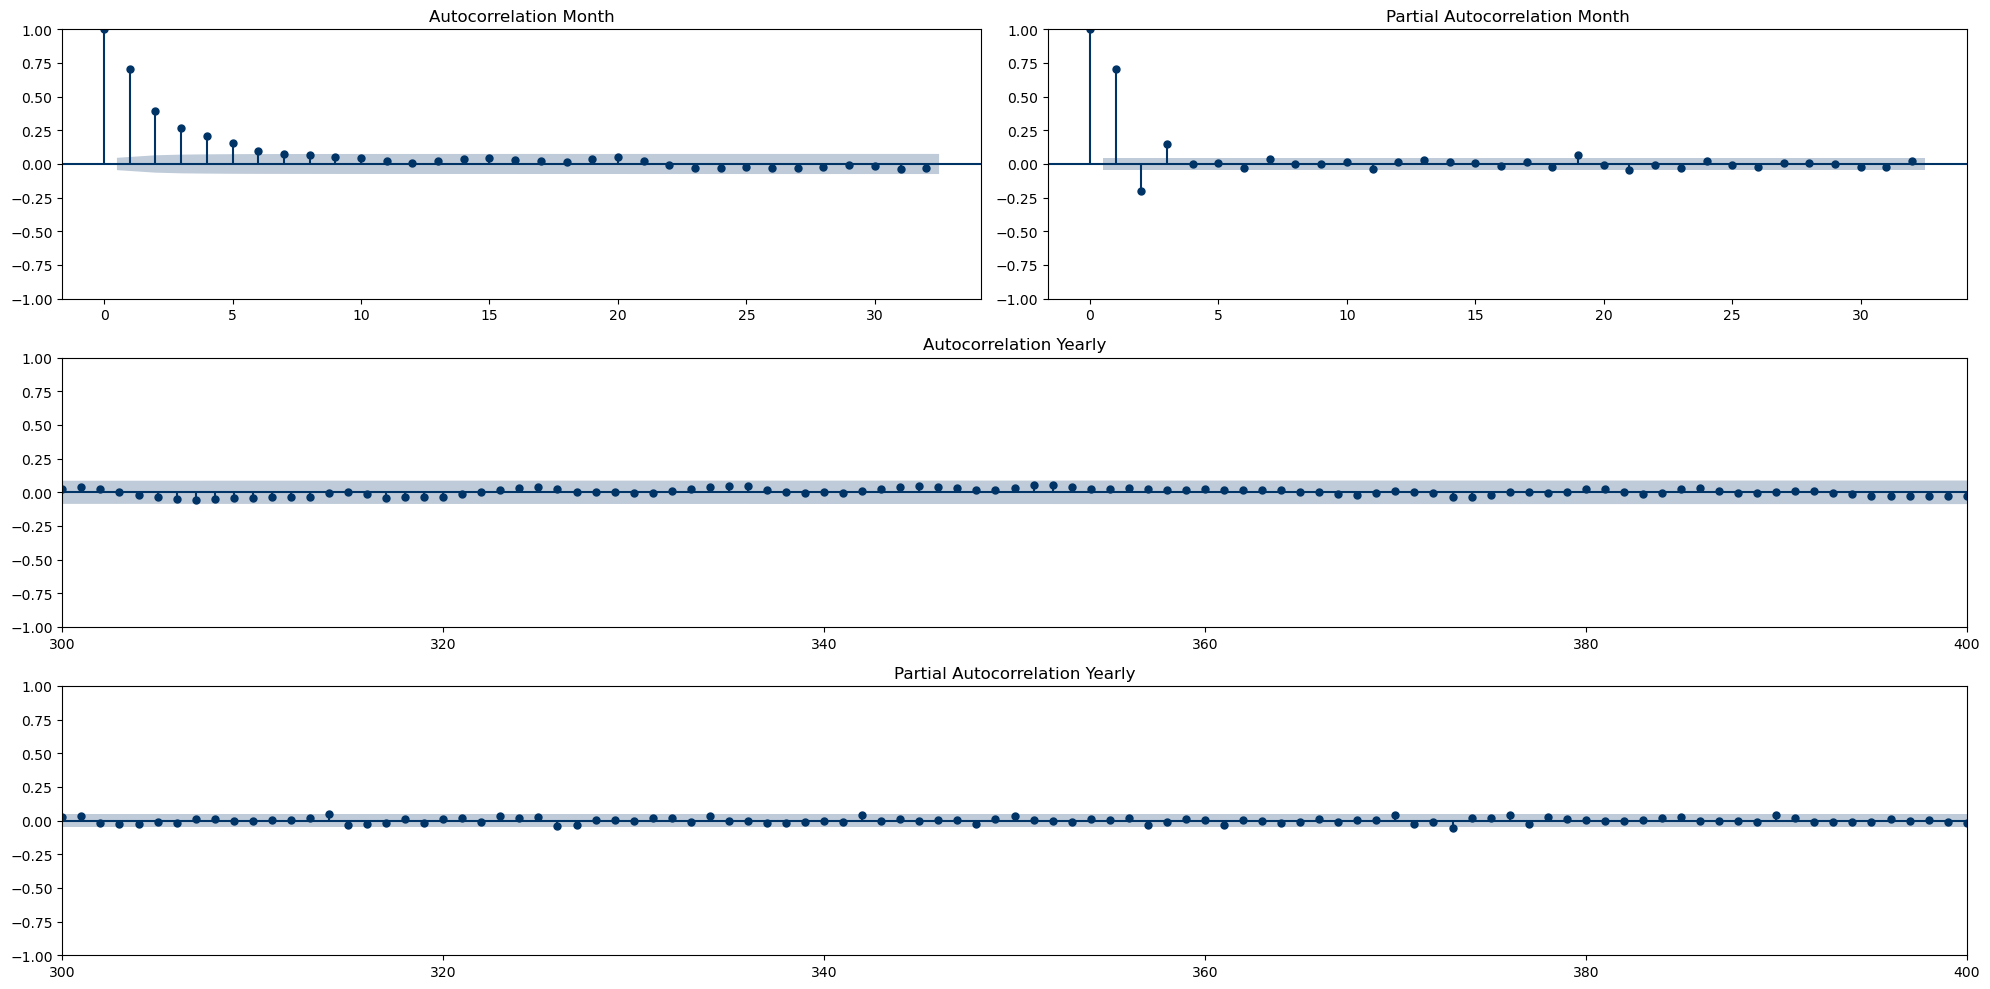

In [17]:
weather_df['tavg_seasonal'] = harmonic_rsae
weather_df['tavg_seasonal_resid'] = weather_df['tavg'] - weather_df['tavg_seasonal']
ts_quick_insights(weather_df['tavg_seasonal_resid'], weather_df['time'])
stationary_tests(weather_df['tavg_seasonal_resid'])
plot_acf_pacf(weather_df['tavg_seasonal_resid'], 'both')


The residuals appear stationary based on statistical tests. However, the autocorrelation function (ACF) and partial autocorrelation function (PACF) plots reveal a progressively decaying autocorrelation at each lag, despite the removal of annual seasonality. This pattern suggests that the data may still exhibit low-frequency dependence, indicating potential non-stationarity and contradicting the earlier test results.

### Ensure Stationarity
To ensure true stationarity, we will apply a standard differencing transformation to eliminate any remaining trends or persistent dependencies.

Augmented Dickey-Fuller (ADF) - p-value: 0.00%
	Ho: Non-Stationarity 
	Ha: Is Stationary
	
Kwiatkowski-Phillips-Schmidt-Shin (KPSS) - p-value: 10.00%
	Ho: Is Stationary
	Ha: Non-Stationarity
	


C:\Users/PedroMoura/Documents/GitHub/WeatherForecast\src\ts_utils.py:40: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  print(f"Kwiatkowski-Phillips-Schmidt-Shin (KPSS) - p-value: {kpss(serie)[1]:.2%}\n"


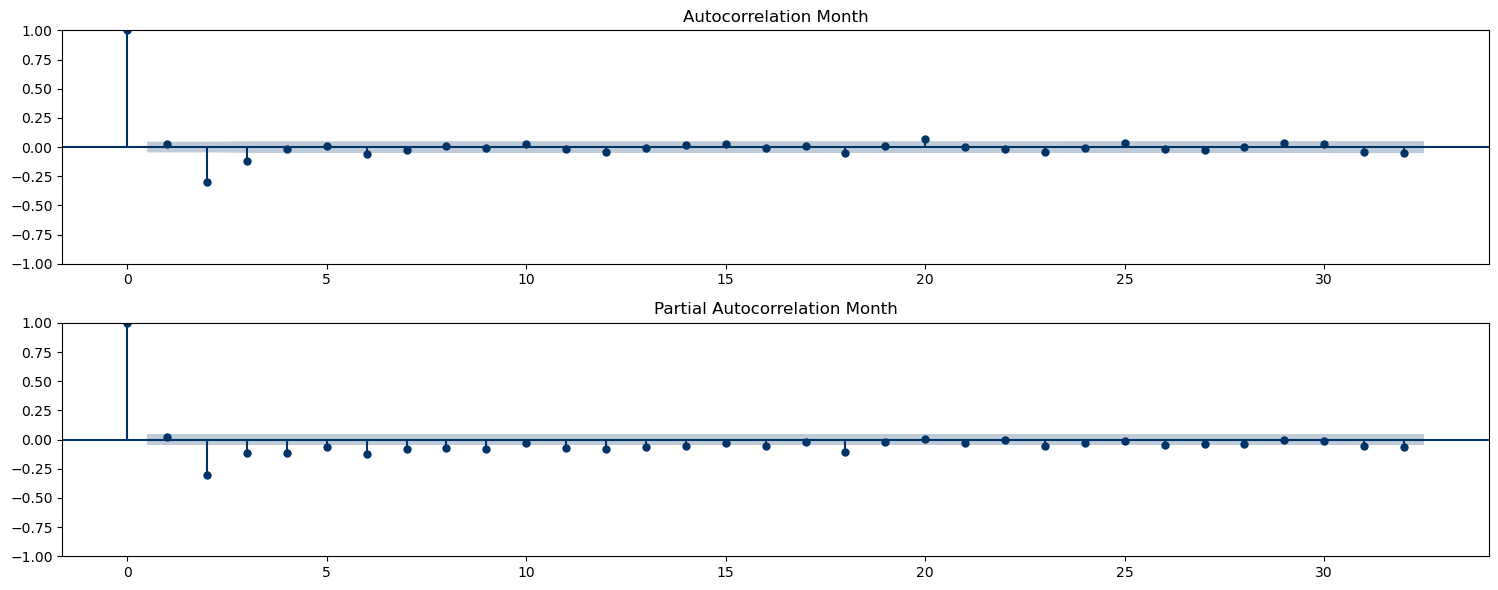

In [18]:
stationary_tests(weather_df['tavg_seasonal_resid'].diff().dropna())
plot_acf_pacf(weather_df['tavg_seasonal_resid'].diff().dropna())

## ARIMA Modeling  
The ACF and PACF plots indicate that autocorrelation is still present in the target variable, suggesting residual temporal dependencies. To address this and achieve a more reliable forecast, we will apply an ARIMA model, which explicitly accounts for autoregressive and moving average structures while ensuring stationarity through differencing.

### Auto Arima

As determined above, the series requires first-order differencing (d=1) to achieve stationarity. Based on the PACF plot, the autoregressive order (p) should be between 2 and 4, as these lags mark the transition out of statistical significance. Similarly, from the ACF plot, the moving average order (q) is likely 2 or 3.

To determine the optimal ARIMA configuration, we will use the auto_arima function, which conducts a grid search over the specified parameter ranges to select the best model based on an information criterion (e.g., AIC or BIC).

In [19]:
auto_arima(weather_df['tavg_seasonal_resid'], d=1,
           start_p=2, max_p=4, 
           start_q=2, max_q=3, 
           seasonal=False, trace=True)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9885.264, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9886.365, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9885.060, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9883.264, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.45 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 4.095 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

Since the Akaike Information Criterion (AIC) penalizes model complexity, it tends to favor simpler models over potentially more accurate but complex ones. This likely explains why auto_arima suggested a random walk model, as AIC prioritizes parsimony over marginal improvements in predictive performance.

### Manual ARIMA
Although the auto_arima method suggested a random walk, we will test an ARIMA(2,1,2) model, as this order exhibited the strongest signal in the previous ACF and PACF analysis.

In [20]:
manual_arima = SARIMAX(weather_df['tavg_seasonal_resid'], order=(2,1,2))
result = manual_arima.fit()
print(result.summary())

                                SARIMAX Results                                
Dep. Variable:     tavg_seasonal_resid   No. Observations:                 1834
Model:                SARIMAX(2, 1, 2)   Log Likelihood               -4742.415
Date:                 Mon, 03 Mar 2025   AIC                           9494.830
Time:                         02:12:46   BIC                           9522.398
Sample:                              0   HQIC                          9504.997
                                - 1834                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3808      0.072      5.272      0.000       0.239       0.522
ar.L2          0.1188      0.058      2.053      0.040       0.005       0.232
ma.L1         -0.4997      0.068     -7.379 

The auto_arima method likely encountered a numerical issue while estimating the ARIMA(2,1,2) model, resulting in an infinite AIC. However, the SARIMAX function successfully fit the model, yielding a finite AIC of 9494.830, which is lower than all other recorded AIC values. This suggests that ARIMA(2,1,2) provides a better fit than the random walk model, which had an AIC of 9885.264.

### Residuals

To verify that all temporal dependencies have been accounted for and removed, we will analyze the residuals.

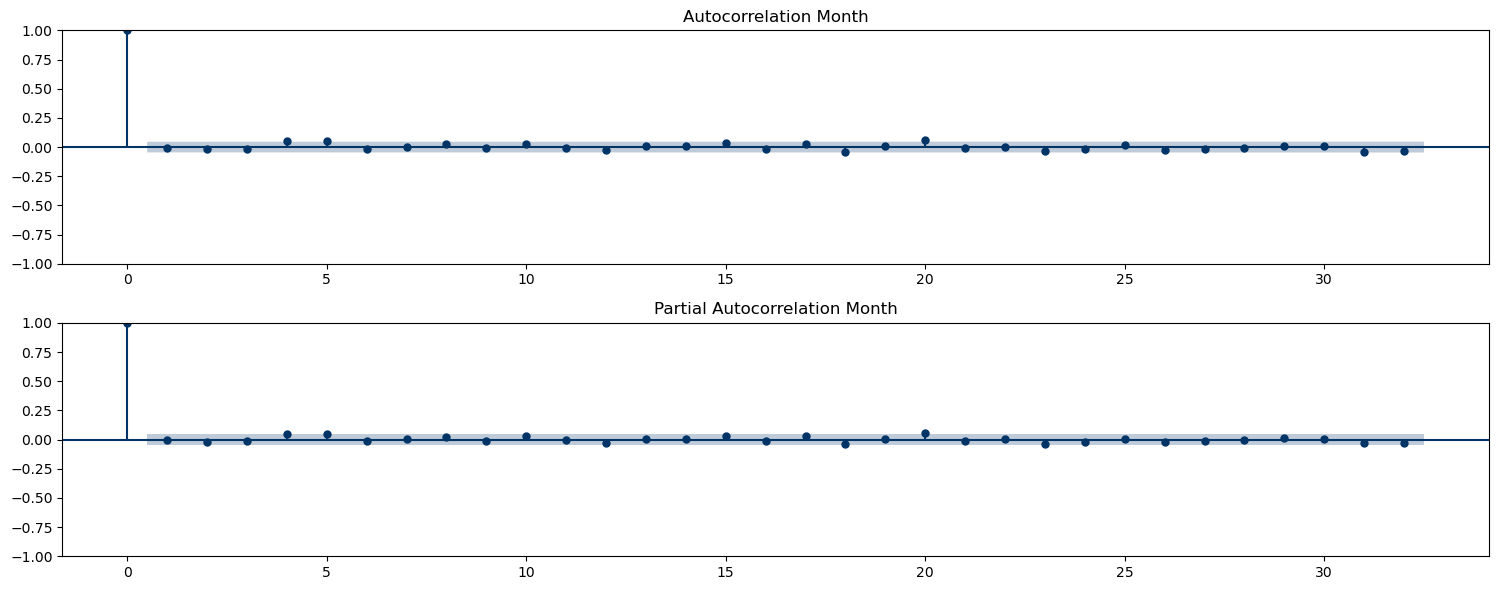

In [21]:
plot_acf_pacf(result.resid)

From the plots above, we can see that all temporal dependencies have been successfully identified and removed, indicating that the residuals behave as white noise.

In [22]:
weather_df['resids'] = result.resid

# Conclusion
Our time series is non-stationary and heteroscedastic. To transform it into a stationary series, we applied a harmonic RSAE regression, which is robust to outliers. We then fit an ARIMA(2,1,2) model to remove the remaining autocorrelation, ensuring that all useful information from the target variable has been extracted. This allows us to proceed with analyzing the residuals alongside other variables.

For the next step, we will explore two possible approaches:
- Regression-based modeling, using techniques such as linear regression (a parametric method) or tree-based models (non-parametric methods).
- Time series modeling, leveraging Granger causality and Vector Autoregression (VAR) to analyze temporal dependencies.

Each approach will be examined in separate notebooks:
- eda_multivariada_temporal (for time series analysis)
- eda_multivariada_regressivo (for regression-based modeling)

In [23]:
weather_df.head()

,time,tavg,prcp,snow,wspd,pres,tamp,wcardinal,tavg_seasonal,tavg_seasonal_resid,resids
0,2018-12-24,271.6,0.0,0.0,3.7,1024.7,5.4,West,273.793970,-2.193970,-2.193970
1,2018-12-25,275.9,0.3,0.0,2.5,1026.1,9.4,South,273.682911,2.217089,4.411060
2,2018-12-26,276.6,0.0,0.0,2.4,1029.6,10.6,Southeast,273.575250,3.024750,0.675633
3,2018-12-27,280.8,16.5,0.0,7.5,1011.5,7.8,Southeast,273.471018,7.328982,5.463847
4,2018-12-28,276.3,0.5,0.0,8.0,1010.3,14.4,Southwest,273.370247,2.929753,-3.863439
